# Grasp Detection

### Comp 341

### Imports

In [1]:
import os
import multiprocessing
import numpy as np 
import time
import cv2
from PIL import Image

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
# from tqdm.std import tqdm, trange
# from tqdm import notebook
# notebook.tqdm = tqdm
# notebook.trange = trange

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torch.optim as optim
torch.backends.cudnn.benchmark = True 
import torchvision as tv

from visualisation import cv2_imshow, rotated_rectangle, imshow
from rect_metric import compare_grasps, grasp_accuracy


print("Using torch", torch.__version__)

Using torch 1.11.0


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


set_seed(42)

In [3]:
# Fetching the device that will be used throughout this notebook

try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
    DATASET_PATH = "drive/MyDrive/Liverpool/Assignments/Year 3/COMP341/COMP341 - Assignment 01 - Data/Data"
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
    !pip install shapely
except:
    IN_COLAB = False
    print('not in colab')
    DATASET_PATH = 'ass1_data/Data/'
    device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:1")
print("Using device", device)

not in colab
Using device cuda:1


In [4]:
featureExtractionPretrainModel = 'model.pretrain.pth'
finalModel = 'finalmodel.pth'
finalDeConvModel = 'finalDeConvModel.pth'
finalConvModel = 'finalConvModel.pth'

### helpers

In [5]:
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_epochs(train_history, validation_history=None, plotType="loss"):
    x = np.arange(1, len(train_history) + 1)
    plt.figure(figsize=(8, 6))
    if validation_history:
        plt.plot(x, validation_history, color=colors[1], label=f"Validation {plotType}", linewidth=2)
    plt.plot(x, train_history, color=colors[0], label=f"Training {plotType}", linewidth=2)
    plt.ylabel(f'{plotType}')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.title(f"Evolution of the training and validation {plotType}")
    plt.show()

In [6]:
def get_cnn_output_size(in_size, kernel_size, stride=1, padding=0):
    integer = int((in_size - kernel_size + 2 * padding) / stride) == ((in_size - kernel_size + 2 * padding) / stride)
    if not integer:
        print("not int", ((in_size - kernel_size + 2 * padding) / stride))
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [7]:
get_cnn_output_size(32, kernel_size=2, stride=2, padding=0)

16

### Load Dataset

#### Augmentation

Expanding the dataset with background augmentation

In [8]:
def generate_augmented_images(root_dir, bk_dir, num_bk):
    for object_name in os.listdir(root_dir):
        for scene_index in range(5):
            scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"

            # Make sure a scene with this index exists for this object
            rgb_path = scene_root + "RGB.png"
            if not os.path.exists(rgb_path): continue

            # Load original image and mask
            rgb = cv2.imread(rgb_path)
            mask = cv2.imread(scene_root + "mask.png")

            for bk_index, background in enumerate(os.listdir(bk_dir)):

                # Load the background image
                bk = cv2.imread(os.path.join(bk_dir, background))[:1024, :1024]

                # get masked foreground
                fg_masked = cv2.bitwise_and(rgb, mask)

                # get masked background, mask must be inverted 
                mask = cv2.bitwise_not(mask)
                bk_masked = cv2.bitwise_and(bk, mask)
                mask = cv2.bitwise_not(mask)  # revert mask to original

                # combine masked foreground and masked background 
                final = cv2.bitwise_or(fg_masked, bk_masked)
                cv2.imwrite(scene_root + f"RGB{bk_index}.png", final)

root_dir = DATASET_PATH + "training"
bk_dir = DATASET_PATH + ("../../backgrounds" if IN_COLAB else "/../backgrounds") # Path to background images
num_bk = len(os.listdir(bk_dir)) # Number of background images
# generate_augmented_images(root_dir, bk_dir, num_bk)

#### Dataset 

In [9]:
class GraspDataset(td.Dataset):
  def __init__(self, root_dir, transforms=None, depth_image=None):
      self.root_dir = root_dir
      self.depth_image = {'perfect':'pDepth', 'stereo': 'sDepth'}.get(depth_image)
      self.transforms = transforms if transforms else tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize(mean=(0.5,), std=(0.5,))])
 
      self.label_dict = {
        "1a9fa4c269cfcc1b738e43095496b061": torch.tensor(0),
        "1d7830c5d0322518d95aa859a460a9ec": torch.tensor(1),
        "2f486fc43af412df22ebff72a57eff4": torch.tensor(2),
        "244cc8707720b66bac7e7b41e1ebe3e4": torch.tensor(3),
        "357e8e4114ebc429e1720743367d35c4": torch.tensor(4),
        "61921ef74746301497380cf93ab53c21": torch.tensor(5),
        "2206259551e94d263321831d2245cf06": torch.tensor(6),
        "b1f4459eae651d4a1e4a40c5ca6a557d": torch.tensor(7),
        "e35c7e8c9f85cac42a2f0bc2931a19e": torch.tensor(8),
        "ffe702c059d0fe5e6617a7fd9720002b": torch.tensor(9)
      }

      if root_dir.split("/")[-1] == "testing":
        self.scene_paths, self.maxGraspLen = load_test_set(root_dir)
        return

      self.maxGraspLen = 0

      # List of all scenes for all objects in the dataset
      self.scene_paths = []
      for object_name in os.listdir(root_dir):
        scene_nums = os.listdir(f"{root_dir}/{object_name}")
        scene_nums = set([file.split("_")[0] for file in scene_nums])

        for scene_index in scene_nums: # Scene index ranges from 0 to 4 for all objects
          scene_root = f"{root_dir}/{object_name}/{scene_index}_{object_name}_"
 
          # Make sure a scene with this index exists for this object
          grasp_path = scene_root + "grasps.txt"
          if os.path.exists(grasp_path):
            grasps = load_grasps(grasp_path)
            if len(grasps) > self.maxGraspLen:
              self.maxGraspLen = len(grasps)
          else:
            raise Exception(f"grasp file does not exist!! ({grasp_path})")
 
          # For each RGB image in the scene
          for bk_index in range(num_bk+1): # +1 for the original image
 
            # If the background index raches the number of backgrounds, set it
            # to an empty string to load the original image
            if bk_index == num_bk: bk_index = ""
            
            scene = {
              "label": object_name,
              "grasp": grasps[0],
              "allGrasps": grasps,
              "rgb": scene_root + f"RGB{bk_index}.png",
              "mask": scene_root + "mask.png",
              "pDepth": scene_root + "perfect_depth.tiff",
              "sDepth": scene_root + "stereo_depth.tiff"
            }
            self.scene_paths.append(scene)
 
  # This must return the length of the dataset
  def __len__(self):
    return len(self.scene_paths)
 
  # This must return the single dataset item at index idx
  def __getitem__(self, idx):

    # Load and convert the label to a tensor
    label = self.label_dict[self.scene_paths[idx]['label']]

    # Load the first grasp in this scene
    grasp = self.scene_paths[idx]['grasp']

    # Load all possible grasps for this scene
    allGrasps = torch.Tensor(self.scene_paths[idx]['allGrasps'])
    allGrasps = F.pad(allGrasps, pad=(0, 0, 0, self.maxGraspLen - allGrasps.shape[0]))
 
    # Load the RGB image
    image = Image.open(self.scene_paths[idx]["rgb"])
    if self.transforms: #do transforms
        image = self.transforms(image)
 
    if self.depth_image is not None:
      depth = Image.open(self.scene_paths[idx][self.depth_image])
      depth = tv.transforms.ToTensor()(depth)
      return (image, grasp, label, allGrasps, depth)
 
    return (image, grasp, label, allGrasps)

In [10]:
def load_test_set(root_dir):
  scene_list = []
  maxGraspLen = 0
  file_list = sorted(os.listdir(root_dir))
  for file_index in range(0, len(file_list), 5): # Each scene has 5 files
    grasp_file = file_list[file_index+1]
    grasps = load_grasps(os.path.join(root_dir, grasp_file))
    if len(grasps) > maxGraspLen:
      maxGraspLen = len(grasps)

    scene = {
      "label": grasp_file.split("_")[1],
      "grasp": grasps[0],
      "allGrasps": grasps,
      "rgb": os.path.join(root_dir, file_list[file_index]),
      "mask": os.path.join(root_dir, file_list[file_index+2]),
      "pDepth": os.path.join(root_dir, file_list[file_index+3]),
      "sDepth": os.path.join(root_dir, file_list[file_index+4])
    }
    scene_list.append(scene)

  return scene_list, maxGraspLen

def load_grasps(grasp_file):
  processLine = lambda line: np.array([float(number) for number in line.split(";")])
  with open(grasp_file) as file:
    grasps = np.array([processLine(line) for line in file.readlines()], dtype=np.float32)
  return grasps

#### Lets look at an image

19
grasp: tensor([774.6070, 782.9183,  52.1016,  22.5000,  27.4022])
label tensor(6)


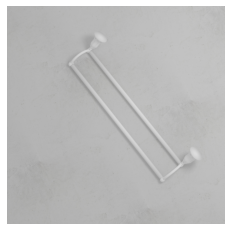

In [11]:
# Show off the dataset
dataset = GraspDataset(DATASET_PATH + "/testing")
print(len(dataset))
# indicies = list(range(len(dataset)))[125:]
# dataset = torch.utils.data.Subset(dataset, indicies)
loader = td.DataLoader(dataset, batch_size=4, shuffle=True, drop_last=False, num_workers=2)
batch = next(iter(loader))
imshow(batch[0][0])

print("grasp:", batch[1][0])
print("label", batch[2][0])
# print("depth:", batch[4][0])

## Boilerplate Code

### loss and optimisers

In [12]:
def getLoss(regression=True):
    if regression:
        return nn.MSELoss()
    else:
        return nn.CrossEntropyLoss()

def getOptimiser(model, learningRate):
    #optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimiser = optim.Adam(model.parameters(), lr=learningRate)
    return optimiser

### Data Loaders

In [13]:
def gen_transforms(resize=None, imgs_mean=(0.5,), imgs_std=(0.5,)):
    tst_trans = [tv.transforms.ToTensor()]
    if resize is not None:
        tst_trans.append(tv.transforms.Resize(resize[0]))
        tst_trans.append(tv.transforms.CenterCrop(resize[1]))
    tst_trans.append(tv.transforms.Normalize(mean=imgs_mean, std=imgs_std))
    return tv.transforms.Compose(tst_trans)

def get_train_loader(batchSize, resize = None, dataset='grasp'): # dataset can = ('grasp', 'perfectDepth', 'stereoDepth', or 'imageNet')
    transforms = gen_transforms(resize)
    if dataset == 'imageNet':
        trainData = tv.datasets.ImageNet(root=f'imageNet/', transform=transforms, split='val')
        imagenetSampler = torch.utils.data.RandomSampler(trainData, num_samples=1000)
        trainLoader = td.DataLoader(trainData, batch_size=batchSize, sampler=imagenetSampler, shuffle=False, drop_last=False, num_workers=int(multiprocessing.cpu_count()/2))
    else:
        trainData = GraspDataset(root_dir=f'{DATASET_PATH}/training', transforms=transforms, depth_image={'perfectDepth':'perfect', 'stereoDepth':'stereo', 'grasp':None}.get(dataset))
        trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=int(multiprocessing.cpu_count()/2))
    return trainLoader

def get_test_loader(batchSize):
    trainData = GraspDataset(root_dir=f'{DATASET_PATH}/testing', transforms=gen_transforms())
    trainLoader = td.DataLoader(trainData, batch_size=batchSize, shuffle=True, drop_last=False, num_workers=int(multiprocessing.cpu_count()/2))
    return trainLoader

### Training functions

#### RGB Only Training Function

In [14]:
def train(model, batch_size, n_epochs, learning_rate, resize=None, usePretrainedBlock=False):
    print(f"batch size: {batch_size}\nn epochs: {n_epochs}\nlearning rate: {learning_rate}\n", "="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossGrasp, lossClassification = getLoss(regression=True), getLoss(regression=False)
    optimizer = getOptimiser(model, learning_rate)
    train_history, accuracy_history = [], []
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    if usePretrainedBlock:
        model.featureExtractionBlock.load_state_dict(torch.load(featureExtractionPretrainModel))
    best_accuracy = 0
    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss, batch_acc = 0, 0
 
        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp, label, allGrasps in tepoch:   #for each batch
                rgb, grasp, label, allGrasps = rgb.to(device), grasp.to(device), label.to(device), allGrasps.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients
 
                # forward + backward + optimize
                grasp_outputs, classification_outputs = model(rgb)
                grasp_loss = lossGrasp(grasp_outputs,  grasp)
                classification_loss = lossClassification(classification_outputs, label)
                loss = grasp_loss + classification_loss # Combine two losses
                loss.backward()
                optimizer.step()
 
                epoch_loss += loss.item()   # add to running totals
                with torch.no_grad():
                    accs = grasp_accuracy(grasp_outputs, allGrasps)
                    batch_acc += accs
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        epoch_acc = batch_acc/len(trainLoader)
        accuracy_history.append(epoch_acc)
        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            torch.save(model.state_dict(), finalModel)
        
    # Show off model outputs from the last batch
    with torch.no_grad():
        for i in range(len(grasp_outputs)):
            print('predicted grasp:', grasp_outputs[i].cpu())
            print('predicted label:', classification_outputs[i].cpu())
            rotated_rectangle(rgb[i].cpu(), grasp_outputs[i].cpu(), grasp[i].cpu())
        accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
        
    print(accuracy_history)
    return train_history, accuracy_history

#### no classification

In [15]:
def train_no_classification(model, batch_size, n_epochs, learning_rate, resize=None):
    print(f"batch size: {batch_size}\nn epochs: {n_epochs}\nlearning rate: {learning_rate}\n", "="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossGrasp, lossClassification = getLoss(regression=True), getLoss(regression=False)
    optimizer = getOptimiser(model, learning_rate)
    train_history, accuracy_history = [], []
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    best_accuracy = 0
    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss, epoch_accuracy = 0, 0

        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp, _, allGrasps in tepoch:   #for each batch
                rgb, grasp, allGrasps = rgb.to(device), grasp.to(device), allGrasps.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients
 
                # forward + backward + optimize
                outputs = model(rgb)
                loss = lossGrasp(outputs,  grasp)
                loss.backward()
                optimizer.step()
 
                epoch_loss += loss.item()   # add to running totals
                with torch.no_grad():
                    accs = grasp_accuracy(outputs, allGrasps)
                    epoch_accuracy += accs
 
        epoch_loss = epoch_loss / len(trainLoader)
        train_history.append(epoch_loss)
        batch_acc = epoch_accuracy/len(trainLoader)
        accuracy_history.append(batch_acc)
        if batch_acc > best_accuracy:
            best_accuracy = batch_acc
            torch.save(model.state_dict(), finalConvModel)
        
    # Show off model outputs from the last batch
    with torch.no_grad():
        for i in range(len(outputs)):
            print('predicted grasp:', outputs[i].cpu())
            rotated_rectangle(rgb[i].cpu(), outputs[i].cpu(), grasp[i].cpu())
        accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
        
    print(accuracy_history)
    return train_history, accuracy_history

#### Pre-training Training Function

In [16]:
def pretrain(model, batch_size, n_epochs, learning_rate, resize=None, mode = 'pretrain'): #mode = 'pretrain' or 'train'
    print(f"batch size: {batch_size}\nn epochs: {n_epochs}\nlearning rate: {learning_rate}\n", "="*20)
    
    trainLoader = get_train_loader(batch_size, resize, 'grasp' if mode == 'train' else 'imageNet')
    lossFn = getLoss(mode == 'train')
    optimizer = getOptimiser(model, learning_rate)

    train_history = []
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    model.featureExtractionBlock.load_state_dict(torch.load(featureExtractionPretrainModel))

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss = 0
        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp, label, allGrasps  in tepoch:   #for each batch
                rgb, grasp, label = rgb.to(device), grasp.to(device), label.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients
                outputs = model(rgb)    
                loss = lossFn(outputs,  grasp)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()# add to running totals
        epoch_loss = epoch_loss / len(trainLoader)
        train_history.append(epoch_loss)
    torch.save(model.featureExtractionBlock.state_dict(), featureExtractionPretrainModel)
    return train_history

#### RGB + Depth Training Function

In [17]:
def train_depth(model, batch_size, n_epochs, learning_rate, resize=None, dataset="perfectDepth", usePretrainedBlock=False):
    print(f"batch size: {batch_size}\nn epochs: {n_epochs}\nlearning rate: {learning_rate}\n", "="*20)
    
    trainLoader = get_train_loader(batch_size, resize, dataset=dataset)
    lossGrasp, lossClassification = getLoss(regression=True), getLoss(regression=False)
    optimizer = getOptimiser(model, learning_rate)
    train_history, accuracy_history = [], []
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    if usePretrainedBlock:
        model.featureExtractionBlock.load_state_dict(torch.load(featureExtractionPretrainModel))

    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss, epoch_accuracy = 0, 0
 
        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp, label, allGrasps, depth in tepoch:   #for each batch
                rgb, grasp, label, allGrasps, depth = rgb.to(device), grasp.to(device), label.to(device), allGrasps.to(device), depth.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients
 
                # forward + backward + optimize
                grasp_outputs, classification_outputs = model(rgb, depth)
                grasp_loss = lossGrasp(grasp_outputs,  grasp)
                classification_loss = lossClassification(classification_outputs, label)
                loss = grasp_loss + classification_loss # Combine two losses
                loss.backward()
                optimizer.step()
 
                epoch_loss += loss.item()   # add to running totals
                with torch.no_grad():
                    accs = grasp_accuracy(grasp_outputs, allGrasps)
                    epoch_accuracy += accs
 
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        batch_acc = epoch_accuracy/len(trainLoader)
        accuracy_history.append(batch_acc)
        if batch_acc > best_accuracy:
            best_accuracy = batch_acc
            torch.save(model.state_dict(), finalDeConvModel)
        
    # Show off model outputs from the last batch
    with torch.no_grad():
        for i in range(len(grasp_outputs)):
            print('predicted grasp:', grasp_outputs[i].cpu())
            print('predicted label:', classification_outputs[i].cpu())
            rotated_rectangle(rgb[i].cpu(), grasp_outputs[i].cpu(), grasp[i].cpu())
        accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
        
    print(accuracy_history)
    return train_history, accuracy_history

### De-Convolution Training

In [18]:
def pos_angle_w_h_to_grasp(pos_output, angle_output, width_output, hight_output):
    batch_size = pos_output.size()[0]
    grasps = torch.zeros((batch_size, 5))
    for idx in range(batch_size):
        grasps[idx] = torch.Tensor([pos_output[idx][0], pos_output[idx][1], angle_output[idx], width_output[idx], hight_output[idx]])
    return grasps
        

def multiheadTrain(model, batch_size, n_epochs, learning_rate, resize=None, optimizer=None, printImages=True):
    print(f"batch size: {batch_size}\nn epochs: {n_epochs}\nlearning rate: {learning_rate}\n", "="*20)
    
    trainLoader = get_train_loader(batch_size, resize)
    lossPosFn, lossAngleFn, lossWidthFn, lossHightFn = getLoss(), getLoss(), getLoss(), getLoss()
    optimizer = getOptimiser(model, learning_rate) if optimizer is None else optimizer
    train_history, accuracy_history = [], []
    
    model = model.to(device) # Move model to gpu
    model.train() # Set the model to training mode (for DropOut)
    for epoch in range(n_epochs):  # loop over the dataset for n_epoch
        epoch_loss, epoch_accuracy = 0, 0
 
        with tqdm(trainLoader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            for rgb, grasp, label, allGrasps in tepoch:   #for each batch
                rgb, grasp, label, allGrasps = rgb.to(device), grasp.to(device), label.to(device), allGrasps.to(device)   # Move tensors to gpu
                optimizer.zero_grad()   # zero the parameter gradients
 
                # forward + backward + optimize
                pos_output, angle_output, width_output, hight_output = model(rgb)
                with torch.no_grad():
                    predicted_grasp = pos_angle_w_h_to_grasp(pos_output, angle_output, width_output, hight_output)
                pos_loss, lossAngle, lossWidth, lossHight = lossPosFn(pos_output, grasp[:,0:2]), lossAngleFn(angle_output, grasp[:,2]), lossWidthFn(width_output, grasp[:,3]), lossHightFn(hight_output, grasp[:,4])
                loss = pos_loss + 1.5 * lossAngle + 10*lossWidth + 14*lossHight
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()   # add to running totals
                with torch.no_grad():
                    accs = grasp_accuracy(predicted_grasp, allGrasps)
                    epoch_accuracy += accs
 
        epoch_loss = epoch_loss / len(trainLoader)
        # print(f"Epoch #{epoch + 1} train_loss: {round(epoch_loss,2)} accuracy: {round(epoch_accuracy,1)}% took: {round(time.time() - start_time,2)}s") 
        train_history.append(epoch_loss)
        batch_acc = epoch_accuracy/len(trainLoader)
        accuracy_history.append(batch_acc)
        
    with torch.no_grad():
        if printImages:
            for i in range(len(predicted_grasp)):
                print('predicted grasp:', predicted_grasp[i].cpu())
                rotated_rectangle(rgb[i].cpu(), predicted_grasp[i].cpu(), grasp[i].cpu())
        accuracy_history = [i.cpu().numpy().item() for i in accuracy_history]
    torch.save(model.state_dict(), finalDeConvModel)
    print(accuracy_history)
    return train_history, accuracy_history

### Testing Functions

In [19]:
def test_2_head(model, batch_size=16):
    test_data = get_test_loader(batch_size)
    model = model.to(device) # Move model to gpu
    model.eval() # Set the model to training mode (for DropOut)
    model.load_state_dict(torch.load(finalModel))
    accuracy = []

    for rgb, grasp, label, allGrasps  in test_data:   #for each batch
        rgb, grasp, label = rgb.to(device), grasp.to(device), label.to(device)   # Move tensors to gpu
        grasp_outputs, _ = model(rgb)    

        with torch.no_grad():
            accs = grasp_accuracy(grasp_outputs, allGrasps, average=False)
            accuracy.extend(accs)
    with torch.no_grad():
        accuracy = sum(accuracy)/len(accuracy)
    return accuracy

def test_multihead(model, batch_size=16):
    test_data = get_test_loader(batch_size)
    model = model.to(device) # Move model to gpu
    model.eval() # Set the model to training mode (for DropOut)
    model.load_state_dict(torch.load(finalDeConvModel))
    accuracy = []

    for rgb, grasp, label, allGrasps  in test_data:   #for each batch
        rgb, grasp, label = rgb.to(device), grasp.to(device), label.to(device)   # Move tensors to gpu
        grasp_outputs, _ = model(rgb)    

        with torch.no_grad():
            accs = grasp_accuracy(grasp_outputs, allGrasps, average=False)
            accuracy.extend(accs)
    with torch.no_grad():
        accuracy = sum(accuracy)/len(accuracy)
    return accuracy

def test_conv(model, batch_size=16):
    test_data = get_test_loader(batch_size)
    model = model.to(device) # Move model to gpu
    model.eval() # Set the model to training mode (for DropOut)
    model.load_state_dict(torch.load(finalConvModel))
    accuracy = []

    for rgb, grasp, label, allGrasps  in test_data:   #for each batch
        rgb, grasp, label = rgb.to(device), grasp.to(device), label.to(device)   # Move tensors to gpu
        grasp_outputs = model(rgb)    

        with torch.no_grad():
            accs = grasp_accuracy(grasp_outputs, allGrasps, average=False)
            accuracy.extend(accs)
    with torch.no_grad():
        accuracy = sum(accuracy)/len(accuracy)
    return accuracy

## Our Models

### ConvNet

In [20]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        # Input image is size 1024x1024
        self.conv1 = nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=0) # output is 510x510
        self.batchN = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 255x255
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1) # output is 128x128
        self.batchN2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 64x64

        self.conv3 = nn.Conv2d(128, 128, kernel_size=2, stride=2, padding=0) # output is 32x32
        self.batchN3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # output is 16x16
        
        self.fc1 = nn.Linear(128 * 16 * 16, 5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchN(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.batchN2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.batchN3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        # flatten tensor
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)

        return x

### ResNet

In [21]:
class ResNetBlock(nn.Module):
    def __init__(self, depth_in, activation_func, depth_out=-1):
        super().__init__()
        self.downSampleResidul = True
        if depth_out == -1:
            depth_out = depth_in
            self.downSampleResidul = False

        self.resBlock = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=3, padding=1, stride=1 if not self.downSampleResidul else 2, bias=False),
            nn.BatchNorm2d(depth_out),
            activation_func(inplace=True),
            nn.Conv2d(depth_out, depth_out, kernel_size=3, padding=1, bias=False)
        )

        self.downsampleRes = nn.Sequential(
            nn.BatchNorm2d(depth_in),
            activation_func(inplace=True),
            nn.Conv2d(depth_in, depth_out, kernel_size=1, stride=2, bias=False)
        )

    def forward(self, x):
        z = self.resBlock(x)
        if self.downSampleResidul:
            x = self.downsampleRes(x)
        return z + x

In [22]:
class DeepGraspResNet(nn.Module):
    def __init__(self, mode = 'train', applyFC=True):
        super(DeepGraspResNet, self).__init__()
        self.applyFC = applyFC
        # self.classificationMode = classificationMode
        #in = 1024 x 1024
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )

        self.block2 = ResNetBlock(32, nn.SiLU, 64)      #out = 127x127
        self.block3 = ResNetBlock(64, nn.SiLU, 128)     #out = 64x64
        self.block4 = ResNetBlock(128, nn.SiLU, 256)    #out = 32x32
        self.block5 = ResNetBlock(256, nn.SiLU, 256)    #out = 16x16

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  #out = 8x8
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 8 * 8

        self.featureExtractionBlock = nn.Sequential(
            self.block1, 
            self.block2, 
            self.block3, 
            self.block4, 
            self.block5
        )

        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size, 1024),
            nn.Dropout(0.2),
            nn.SiLU(inplace=True),
            nn.Linear(1024, 5 if mode == 'train' else 1000),
        )
        # self.classification = nn.SoftMax()

        self.classificationBlock = nn.Sequential(
            nn.Linear(self.flattened_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.featureExtractionBlock(x)
        x = self.pool(x)
        x = x.view(-1, self.flattened_size)
        if self.applyFC:
            grasp = self.regressionBlock(x)
            classification = self.classificationBlock(x)
            return (grasp, classification)
        return x

### De-Convolution Network

In [23]:
class DeConvResNet(nn.Module):
    def __init__(self, dropout=0.3):
        super(DeConvResNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )
        self.featureExtractionBlock = nn.Sequential(
            ResNetBlock(32, nn.SiLU, 64),      #out = 127x127
            ResNetBlock(64, nn.SiLU, 128),      #out = 64x64
            ResNetBlock(128, nn.SiLU, 128),     #out = 32x32
            ResNetBlock(128, nn.SiLU),    #out = 32x32
            ResNetBlock(128, nn.SiLU, 128),    #out = 16x16
        )

        self.convTrasposeBlock = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=9, stride=1, padding=4)  #out = 64x64
        )
        self.flattened_size = 64*64
        self.pos_conv = nn.Conv2d(32, 2, kernel_size=2)
        self.angle_conv = nn.Conv2d(32, 1, kernel_size=2)
        self.width_conv = nn.Conv2d(32, 1, kernel_size=2)
        self.hight_conv = nn.Conv2d(32, 1, kernel_size=2)

        self.pos_output = nn.Sequential(nn.Linear(self.flattened_size*2, 512), nn.Linear(512, 2))
        self.angle_output = nn.Sequential(nn.Linear(self.flattened_size, 512), nn.Linear(512, 1))
        self.width_output = nn.Sequential(nn.Linear(self.flattened_size, 512), nn.Linear(512, 1))
        self.hight_output = nn.Sequential(nn.Linear(self.flattened_size, 512), nn.Linear(512, 1))

        self.dropout = nn.Dropout(dropout)

        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, x):
        x = self.block1(x)
        x = self.featureExtractionBlock(x)
        x = self.convTrasposeBlock(x)
        pos_output = self.pos_output(self.pos_conv(self.dropout(x)).view(-1, self.flattened_size*2))
        angle_output = self.angle_output(self.angle_conv(self.dropout(x)).view(-1, self.flattened_size)).flatten()
        width_output = self.width_output(self.width_conv(self.dropout(x)).view(-1, self.flattened_size)).flatten()
        hight_output = self.hight_output(self.hight_conv(self.dropout(x)).view(-1, self.flattened_size)).flatten()
        return pos_output, angle_output, width_output, hight_output

### Depth ResNet

In [24]:
class DepthResNet(nn.Module):
    def __init__(self, mode='train'):
        super(DepthResNet, self).__init__()
        self.rgb_side = DeepGraspResNet(applyFC=False)

        # self.classificationMode = classificationMode
        #in = 1024 x 1024
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=0), #out = 511x511
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(16),
            # nn.Dropout(0.3),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0), #out = 509x509
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0), #out = 507x507
            nn.SiLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=0) #out = 253x253
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 253x253
        )
 
        self.block2 = ResNetBlock(32, nn.SiLU, 64)      #out = 127x127
        self.block3 = ResNetBlock(64, nn.SiLU, 128)     #out = 64x64
        self.block4 = ResNetBlock(128, nn.SiLU, 256)    #out = 32x32
        self.block5 = ResNetBlock(256, nn.SiLU, 256)    #out = 16x16
 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  #out = 8x8
        # self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.flattened_size = 256 * 8 * 8
 
        self.featureExtractionBlock = nn.Sequential(
            self.block1, 
            self.block2, 
            self.block3, 
            self.block4, 
            self.block5
        )
 
        self.regressionBlock = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.flattened_size*2, 1024),
            nn.Dropout(0.2),
            nn.SiLU(inplace=True),
            nn.Linear(1024, 5 if mode == 'train' else 1000),
        )
        # self.classification = nn.SoftMax()
 
        self.classificationBlock = nn.Sequential(
            nn.Linear(self.flattened_size*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )
 
    def forward(self, rgb, x):
      rgb_output = self.rgb_side(rgb)
      x = self.featureExtractionBlock(x)
      x = self.pool(x)
      x = x.view(-1, self.flattened_size)
      x = torch.cat((rgb_output, x), 1)
      grasp = self.regressionBlock(x)
      classification = self.classificationBlock(x)
      return (grasp, classification)

### Train Networks

In [25]:
network = 'DeepResNet' # choices are ('DeepResNet', 'Conv', 'PreTrainDeepResNet' or 'depthResNet')

torch.cuda.empty_cache()

if network == 'DeepResNet':
  BATCH_SIZE = 16
  EPOCHS = 30
  LEARNING_RATE = 0.00103
  nnet = DeepGraspResNet()
  train_loss, train_acc = train(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, usePretrainedBlock = True)
elif network == 'PreTrainDeepResNet':
  resize = (1024, 1024)
  EPOCHS = 10
  BATCH_SIZE = 16
  LEARNING_RATE = 0.01
  nnet = DeepGraspResNet(mode='pretrain')
  train_loss, train_acc = pretrain(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE, resize=resize)
elif network == 'Conv':
  BATCH_SIZE = 10
  EPOCHS = 10
  LEARNING_RATE = 0.001
  nnet = ConvNN()
  train_loss, train_acc = train_no_classification(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE)
elif network == 'depthResNet':
  BATCH_SIZE = 10
  EPOCHS = 10
  LEARNING_RATE = 0.001
  nnet = DepthResNet()
  train_loss, train_acc = train_depth(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE)
elif network == 'DeConv':
  BATCH_SIZE = 16
  EPOCHS = 10
  LEARNING_RATE = 0.001
  nnet = DeConvResNet()
  train_loss, train_acc = multiheadTrain(nnet, BATCH_SIZE, EPOCHS, LEARNING_RATE)


batch size: 16
n epochs: 30
learning rate: 0.00103


  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

  0%|          | 0/11 [00:00<?, ?batch/s]

### test networks

In [26]:
models = {"DeepResNet":DeepGraspResNet, "Conv":ConvNN, "depthResNet":DepthResNet}
if network == 'DeepResNet':
    net = DeepGraspResNet()
    result = test_2_head(net)
elif network == 'Conv':
    net = ConvNN()
    result = test_conv(net)
elif network == 'DeConv':
    net = DeConvResNet()
    result = test_multihead(net)
print("ovreall result =", result.item())

tensor(0.2142)

### loss and accuracy plots

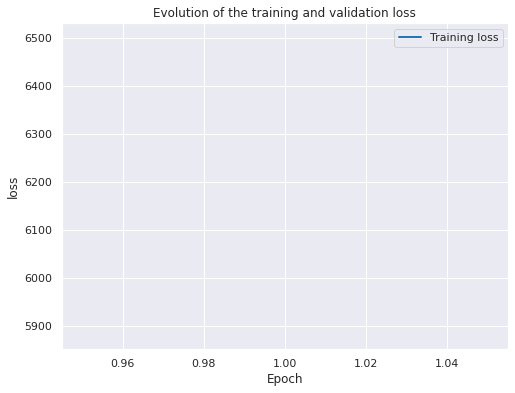

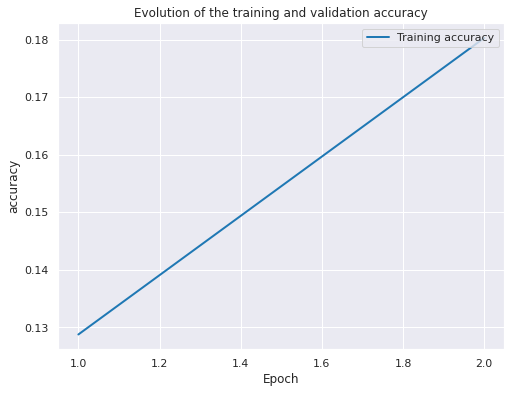

In [ ]:
plot_epochs(train_loss)
plot_epochs(train_acc, plotType="accuracy")

### Hyper-parameter tuning

In [24]:
def learning_rate_search(lrs):
    results = {}
    for lr in lrs:
        train_loss, train_acc = train(nnet, BATCH_SIZE, EPOCHS, lr)
        results[lr] = (train_loss, train_acc)
    return results
lrResults = learning_rate_search([0.1, 0.01, 0.001, 0.0001, 0.00001])

batch size: 10
n epochs: 2
learning rate: 0.1


  0%|          | 0/29 [00:00<?, ?batch/s]

TypeError: ignored

In [ ]:
import optuna
def optuna_objective(trial):
    EPOCHS = 8
    # dropOut=trial.suggest_uniform("dropout", 0.1, 0.5)
    # linearSize=trial.suggest_int("linear_layer_size", 256, 8192)
    # pool = trial.suggest_int("pool_num", 1, 2)
    # model = DeepGraspResNet(dropOut=dropOut, linearSize=linearSize, pool=pool)
    model = DeepGraspResNet()
    # optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-4, 5e-2)
    # batchSize=trial.suggest_int("batch_size", 8, 16)
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    # usePreTrain = trial.suggest_int("pre_trainer?", 1, 2)
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
# run_optuna()

# result = {lr: 0.000103}